<a href="https://colab.research.google.com/github/CWill22/NeuralHW3/blob/main/Will_Curry_XOR_FCN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

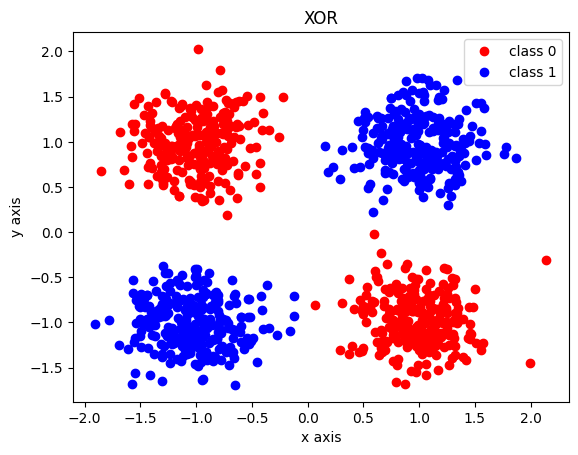

In [177]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(0)
rng = np.random.RandomState(0)
X = rng.randn(1000, 2)
X = (X > 0) * 2 - 1 + 0.3 * rng.randn(*X.shape)
Y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)

c0 = X[np.nonzero(Y)[0]]
c1 = X[np.nonzero(Y == 0)[0]]

plt.plot(c0[:,0], c0[:,1], 'ro', label='class 0')
plt.plot(c1[:,0], c1[:,1], 'bo', label='class 1')

plt.title('XOR')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend()
plt.show()

In [178]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size=8

training_data = DataLoader(TensorDataset(torch.Tensor(X[:750,:]), torch.tensor(Y[:750], dtype=torch.long)), shuffle=True, batch_size=batch_size)
validation_data = DataLoader(TensorDataset(torch.Tensor(X[750:,:]), torch.tensor(Y[750:], dtype=torch.long)), batch_size=batch_size)

In [179]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.activation = nn.ReLU()
        #self.first_hidden = nn.Linear(2, 10)
        self.first_hidden = nn.Linear(2, 2)
        #self.second_hidden = nn.Linear(10, 5)
        self.output = nn.Linear(2, 2)

    def forward(self, x):
        x = self.activation(self.first_hidden(x))
        #x = self.activation(self.second_hidden(x))
        x = self.output(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (activation): ReLU()
  (first_hidden): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=2, bias=True)
)


In [180]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

In [181]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [182]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [183]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data, model, loss_fn, optimizer)
    test(validation_data, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.340970  [    0/  750]
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.431088 

Epoch 2
-------------------------------
loss: 0.462903  [    0/  750]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.272465 

Epoch 3
-------------------------------
loss: 0.202847  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.186774 

Epoch 4
-------------------------------
loss: 0.178170  [    0/  750]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.144009 

Epoch 5
-------------------------------
loss: 0.475913  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.114835 

Epoch 6
-------------------------------
loss: 0.162319  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.097584 

Epoch 7
-------------------------------
loss: 0.148501  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.086242 

Epoch 8
-------------------------------
loss: 0.118146  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.078012 

Epoch 9
----------------

In [184]:
def predict(x):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
    #Predict and return ans
    ans = torch.argmax(model(x), dim=1)
    return ans.to('cpu').detach().numpy()

In [185]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.title('XOR')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    # Plot ground truth
    c0 = X[np.nonzero(Y)[0]]
    c1 = X[np.nonzero(Y == 0)[0]]
    plt.plot(c0[:,0], c0[:,1], 'ko', label='class 0')
    plt.plot(c1[:,0], c1[:,1], 'wo', label='class 1')
    plt.legend()

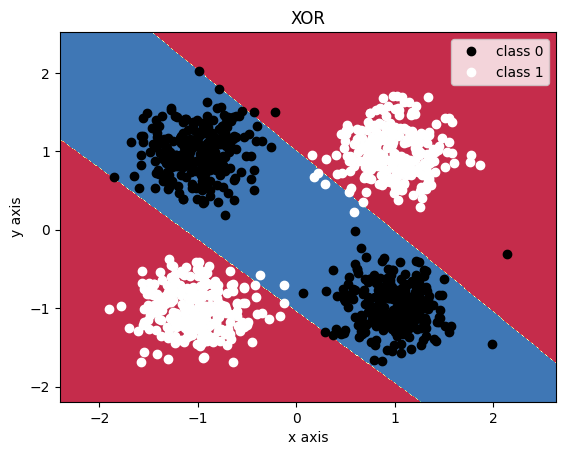

In [186]:
plot_decision_boundary(predict, X, Y)

# 3 Perceptron Network
dataset and functions

In [187]:
import numpy as np

#same dataset as above
rng = np.random.RandomState(0)
X = rng.randn(1000, 2)
X = (X > 0) * 2 - 1 + 0.3 * rng.randn(*X.shape)
Y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)

def step(x):
    """Heaviside step: returns 1 if x >= 0, else 0."""
    return 1 if x >= 0 else 0

def perceptron_1(x):
    """
    Hidden perceptron #1 (h1)
    Fires if x1 + x2 >= -0.5
    => line boundary: x2 = -x1 - 0.5
    """
    return step(x[0] + x[1] + 0.5)

def perceptron_2(x):
    """
    Hidden perceptron #2 (h2)
    Fires if -x1 - x2 >= -0.5
    => line boundary: x2 = -x1 + 0.5
    """
    return step(-x[0] - x[1] + 0.5)

def perceptron_3(h1, h2):
    """
    Output perceptron.
    Combines the two hidden signals so that output = 1
    iff exactly one of h1 or h2 is 1.
    """
    return step(h1 + h2 - 1.5)

def xor_network(x):
    """
    The overall 3-perceptron network:
      2 hidden perceptrons + 1 output perceptron.
    """
    h1 = perceptron_1(x)
    h2 = perceptron_2(x)
    out = perceptron_3(h1, h2)
    return out


run and evaluate

In [188]:
# Suppose X is your Nx2 numpy array of inputs,
# and Y is the corresponding XOR labels (0 or 1).

preds = np.array([xor_network(xi) for xi in X])
accuracy = np.mean(preds == Y)
print("Accuracy of 3 perceptron XOR network:", accuracy)


Accuracy of 3 perceptron XOR network: 0.893


Plot new decision boundary

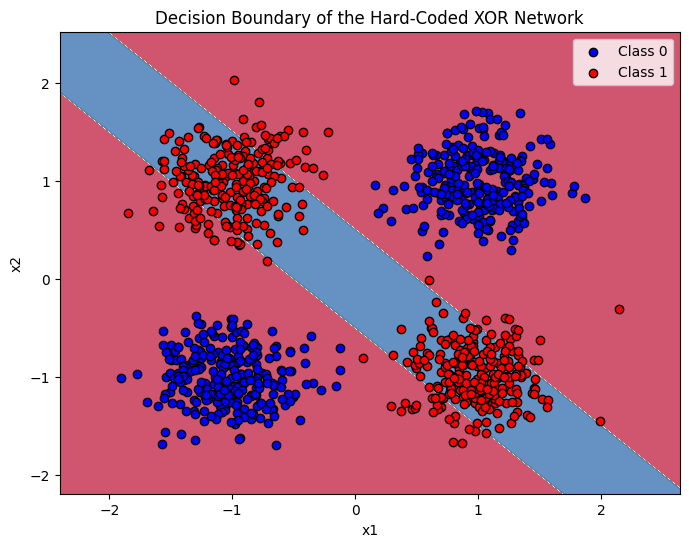

In [189]:
def plot_decision_boundary(predict_func, X, Y, resolution=0.01):
    """
    Plots the decision boundary of a given prediction function.

    Parameters:
    - predict_func: A function that takes a 2D point and returns 0 or 1.
    - X: (N x 2) numpy array of input features.
    - Y: (N,) numpy array of true labels.
    - resolution: grid step size.
    """
    # Determine the boundaries of the plot with some padding.
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a grid of points.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Compute predictions over the grid.
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([predict_func(point) for point in grid_points])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary.
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # Overlay the original dataset.
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c='blue', edgecolor='k', label='Class 0')
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c='red', edgecolor='k', label='Class 1')

    plt.title('Decision Boundary of the Hard-Coded XOR Network')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

# 4. Run the network on the dataset and visualize the decision boundary.
plot_decision_boundary(xor_network, X, Y)